In [102]:
import pandas as pd

In [103]:
df = pd.read_csv("hf://datasets/KalaiselvanD/kalai_priority_new/prioritynew1.csv")

In [104]:
#print data sample of 5 and shape
print(f"Data sample: \n{df.head()}")
print(f"Data shape: {df.shape}")

Data sample: 
   label                                      text
0      2                 This is a critical issue.
1      1                 This is a moderate issue.
2      0                    This is a minor issue.
3      2  This issue requires immediate attention.
4      1      This issue should be addressed soon.
Data shape: (7085, 2)


## Data Pre-processing
Convert to available dataset having columns - "processed_text" and "urgency"

In [105]:
# Add high, medium and low label for 2,1,0 respectively
df['priority'] = df['label'].replace({2: 'high', 1: 'medium', 0: 'low'})
df.head()

,label,text,priority
0,2,This is a critical issue.,high
1,1,This is a moderate issue.,medium
2,0,This is a minor issue.,low
3,2,This issue requires immediate attention.,high
4,1,This issue should be addressed soon.,medium


In [106]:
df['urgency'] = df['priority'].apply(lambda x: 'urgent' if x == 'high' else 'not_urgent')
df.head()

,label,text,priority,urgency
0,2,This is a critical issue.,high,urgent
1,1,This is a moderate issue.,medium,not_urgent
2,0,This is a minor issue.,low,not_urgent
3,2,This issue requires immediate attention.,high,urgent
4,1,This issue should be addressed soon.,medium,not_urgent


In [107]:
# rename text column to processed_text
df.rename(columns={'text': 'processed_text'}, inplace=True)

In [108]:
df[df.label.isna()]

,label,processed_text,priority,urgency


In [109]:
df.text.nunique()

AttributeError: 'DataFrame' object has no attribute 'text'

### Data Visualization using TF-IDF Vectorizer

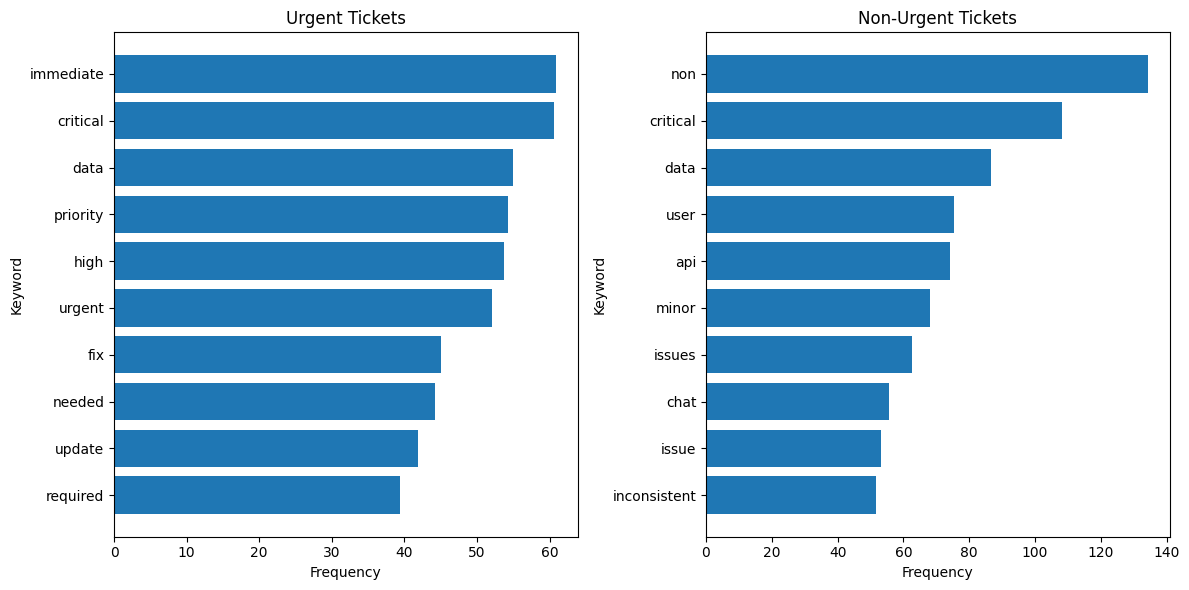

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

urgent_tickets = df[df['urgency'] == 'urgent']
non_urgent_tickets = df[df['urgency'] != 'urgent']

def create_charts(ax, df, title): 
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['processed_text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()
    
# two on one row
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
create_charts(axs[0], urgent_tickets, 'Urgent Tickets')
create_charts(axs[1], non_urgent_tickets, 'Non-Urgent Tickets')
plt.tight_layout()


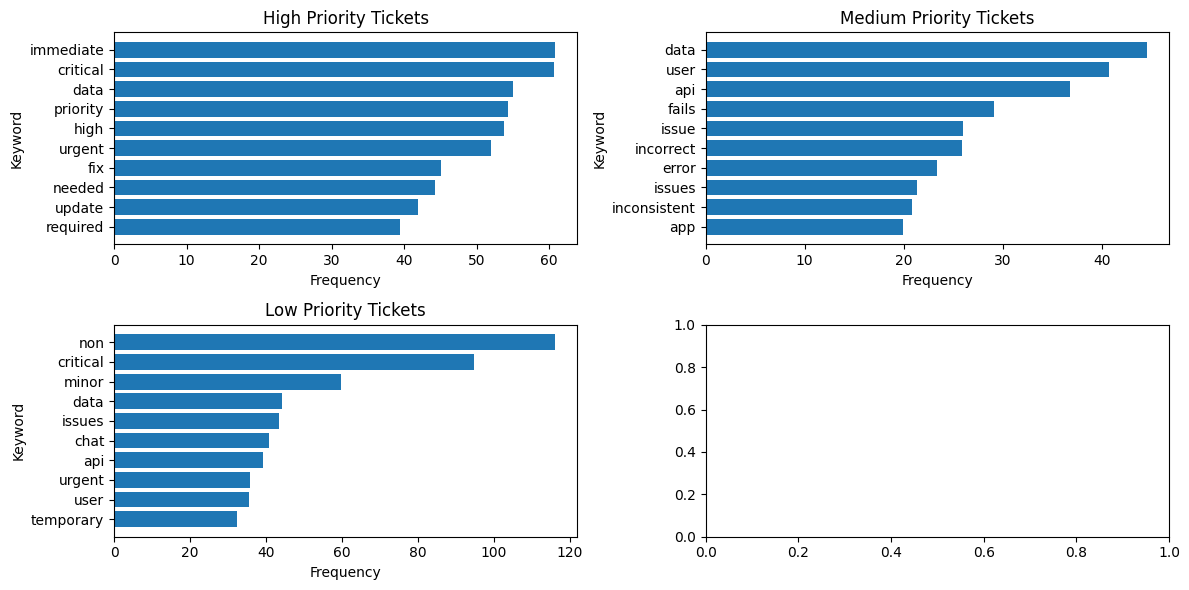

In [23]:
# For high, medium and low label
high_priority_tickets = df[df['priority'] == 'high']
medium_priority_tickets = df[df['priority'] == 'medium']
low_priority_tickets = df[df['priority'] == 'low']

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
create_charts(axs[0, 0], high_priority_tickets, 'High Priority Tickets')
create_charts(axs[0, 1], medium_priority_tickets, 'Medium Priority Tickets')
create_charts(axs[1, 0], low_priority_tickets, 'Low Priority Tickets')
plt.tight_layout()

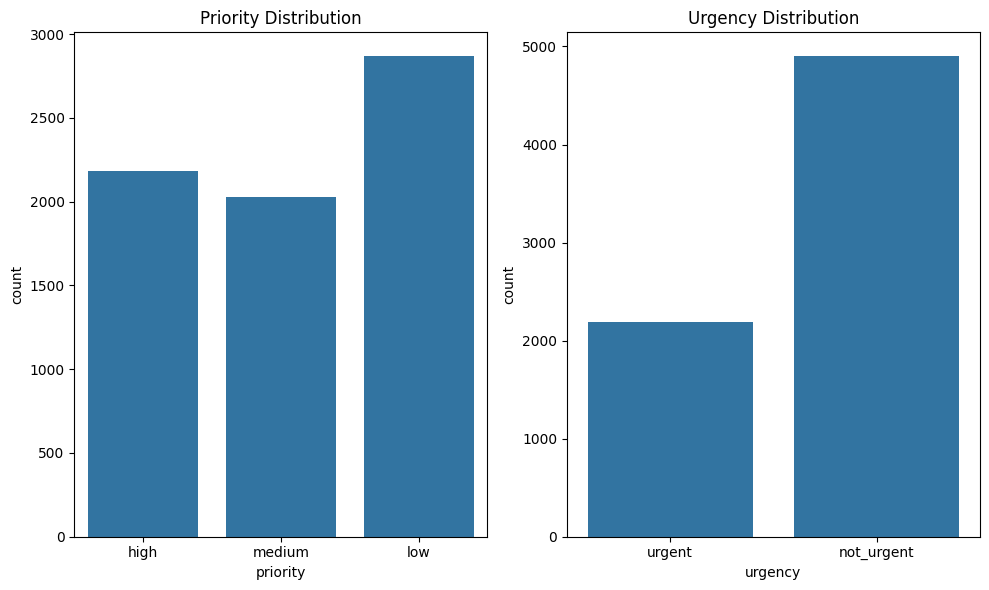

In [ ]:
# Check the distribution of the labels
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x='priority', data=df, ax=axs[0])
axs[0].set_title('Priority Distribution')
sns.countplot(x='urgency', data=df, ax=axs[1])
axs[1].set_title('Urgency Distribution')
plt.tight_layout()

**Conclusion** : Will be training model using labels instead of merging into urgency due to higher data variation

In [79]:
from sklearn.model_selection import train_test_split

X = df[['processed_text']]
y = df['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'processed_text')
    ],
)

pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

In [ ]:
pipeline_logreg.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text_tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'processed_text')])),
                ('classifier', SVC(random_state=42))])

In [82]:
y_pred_logreg = pipeline_logreg.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)

print(f"Logistic Regression Classification Report: \n{classification_report(y_test, y_pred_logreg)}")
print(f"SVM Classification Report: \n{classification_report(y_test, y_pred_svm)}")

Logistic Regression Classification Report: 
              precision    recall  f1-score   support

        high       0.81      0.72      0.76       431
         low       0.71      0.80      0.75       567
      medium       0.57      0.54      0.56       419

    accuracy                           0.70      1417
   macro avg       0.70      0.69      0.69      1417
weighted avg       0.70      0.70      0.70      1417

SVM Classification Report: 
              precision    recall  f1-score   support

        high       0.83      0.69      0.76       431
         low       0.71      0.83      0.76       567
      medium       0.57      0.53      0.55       419

    accuracy                           0.70      1417
   macro avg       0.70      0.68      0.69      1417
weighted avg       0.70      0.70      0.70      1417



In [47]:
# Example of prediction
example_text = pd.DataFrame([
    'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently'
    ],
    columns=['processed_text'])

print(f"Logistic Regression Prediction: {pipeline_logreg.predict(example_text)}")

Logistic Regression Prediction: ['high' 'low' 'medium' 'medium' 'medium']


### Adding one more dataset from Hugging Face

In [49]:
import pandas as pd

splits = {'train': 'train.csv', 'validation': 'val.csv', 'test': 'test.csv'}

df_emails = pd.read_csv("hf://datasets/vedaantp/email-priority/" + splits["train"])

In [50]:
df_emails.head()

,text,label
0,Frequent crashes on macOS with Adobe Photoshop...,2
1,= ? utf - 8 ? q ? xmas wishlist - role ? = = ?...,0
2,Frequent connectivity drops with the Cisco rou...,3
3,"miningnews . net newsletter - thursday , janua...",0
4,Assistance Needed for Project Dear support tea...,1


In [51]:
df_emails['priority'] = df_emails['label'].replace({2: 'high', 1: 'medium', 0: 'low'})
df_emails['urgency'] = df_emails['priority'].apply(lambda x: 'urgent' if x == 'high' else 'not_urgent')

df_emails.rename(columns={'text': 'processed_text'}, inplace=True)
df_emails.sample(5)

,processed_text,label,priority,urgency
184,impress your girl with a huge cumshot ! heya !...,0,low,not_urgent
197,Ticket Notification Issue Dear Customer Suppor...,3,3,not_urgent
354,Urgent: Immediate Assistance Required for Serv...,3,3,not_urgent
525,women change your life,0,low,not_urgent
300,Ticket attached problem needs resolution in Jira.,2,high,urgent


In [56]:
print(f"Empty texts: {df_emails[df_emails['processed_text'].isna()].shape[0]}")
print(f"Empty labels: {df_emails[df_emails['label'].isna()].shape[0]}")

Empty texts: 0
Empty labels: 0


In [55]:
df_emails.dropna(subset=['processed_text'], inplace=True)

In [62]:
df_emails.sample(5)

,processed_text,label,priority,urgency
388,Screen problem flashing Hello customer support...,3,3,not_urgent
165,fehler bei unserem newsletter versand sehr gee...,0,low,not_urgent
47,Zoom crashes during Customer Customer Support ...,3,3,not_urgent
368,refill order verification % rnd _ alt % rnd _ ...,0,low,not_urgent
18,Inquiry on Surface Pro 7 Monitor Compatibility...,2,high,urgent


In [59]:
# number of urgent and non-urgent emails
print(f"Urgent emails: {df_emails[df_emails['urgency'] == 'urgent'].shape[0]}")
print(f"Non-urgent emails: {df_emails[df_emails['urgency'] != 'urgent'].shape[0]}")

Urgent emails: 123
Non-urgent emails: 416


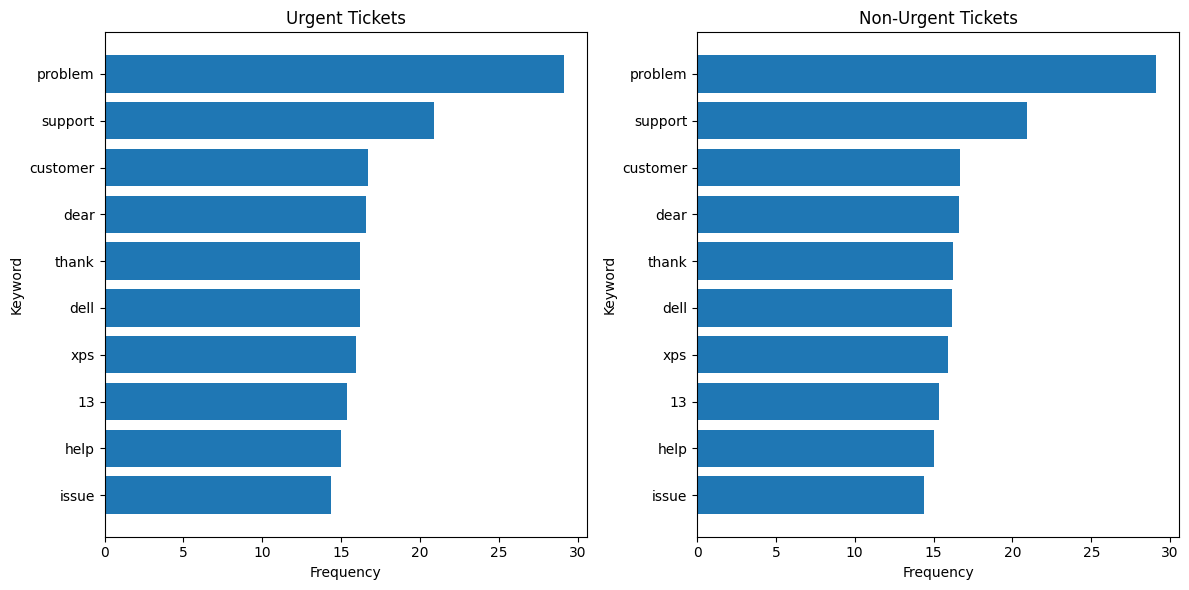

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

urgent_tickets = df_emails[df_emails['urgency'] == 'urgent']
non_urgent_tickets = df_emails[df_emails['urgency'] != 'urgent']

def create_charts(ax, df, title): 
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df_emails['processed_text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()
    
# two on one row
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
create_charts(axs[0], urgent_tickets, 'Urgent Tickets')
create_charts(axs[1], non_urgent_tickets, 'Non-Urgent Tickets')
plt.tight_layout()


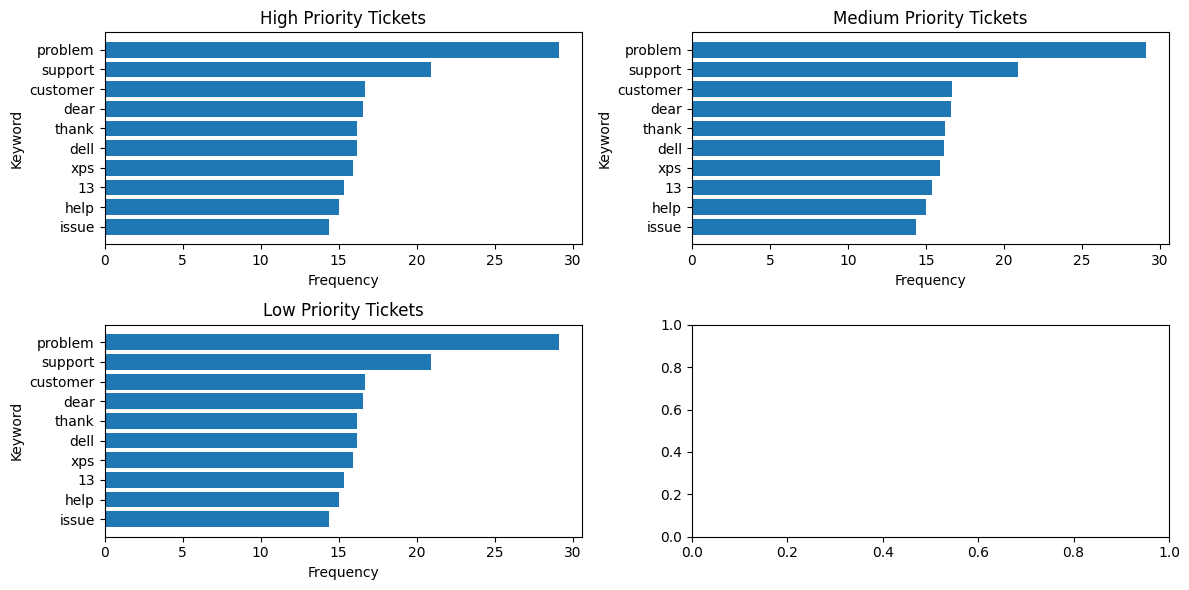

In [60]:
# For high, medium and low label
high_priority_tickets = df_emails[df_emails['priority'] == 'high']
medium_priority_tickets = df_emails[df_emails['priority'] == 'medium']
low_priority_tickets = df_emails[df_emails['priority'] == 'low']

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
create_charts(axs[0, 0], high_priority_tickets, 'High Priority Tickets')
create_charts(axs[0, 1], medium_priority_tickets, 'Medium Priority Tickets')
create_charts(axs[1, 0], low_priority_tickets, 'Low Priority Tickets')
plt.tight_layout()

### Since keyswords have same importance in all three categories of emails, we will be ignoring this dataset

In [ ]:
# store df 
df.to_csv("../csv/hf_priority.csv", index=False)

## Creating model again using my existing dataset

In [71]:
df_processed = pd.read_csv("../csv/processed_tickets_en.csv")
print(f"Data sample: \n{df_processed.head()}")
print(f"Data shape: {df_processed.shape}")

Data sample: 
                                      processed_text      type  \
0  Urgent: Critical impact on enterprise network ...  Incident   
1  Intermittent Cursor Freezing Issue on Dell XPS...  Incident   
2  Urgent: Support needed for data recovery of My...  Incident   
3  Inquiry about MacBook Air M1 features. Dear Cu...   Request   
4  Request Assistance with Office 365 Installatio...   Problem   

                 queue priority     urgency  
0    Technical Support     high      urgent  
1      Product Support      low  not_urgent  
2    Technical Support     high      urgent  
3  Sales and Pre-Sales      low  not_urgent  
4    Technical Support   medium  not_urgent  
Data shape: (1564, 5)


In [72]:
# combining the two datasets
df_combined = pd.concat([df, df_processed], ignore_index=True)
print(f"Data shape: {df_combined.shape}")
print(f"Data sample: \n{df_combined.head()}")

Data shape: (8649, 6)
Data sample: 
   label                            processed_text priority     urgency type  \
0    2.0                 This is a critical issue.     high      urgent  NaN   
1    1.0                 This is a moderate issue.   medium  not_urgent  NaN   
2    0.0                    This is a minor issue.      low  not_urgent  NaN   
3    2.0  This issue requires immediate attention.     high      urgent  NaN   
4    1.0      This issue should be addressed soon.   medium  not_urgent  NaN   

  queue  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  


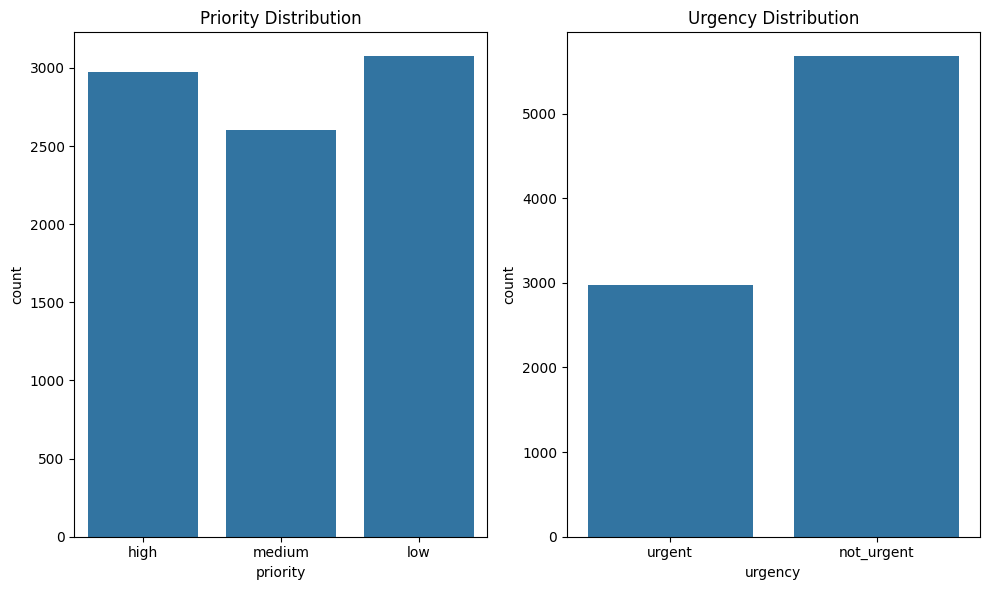

In [77]:
# Check the distribution of the labels
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x='priority', data=df_combined, ax=axs[0])
axs[0].set_title('Priority Distribution')
sns.countplot(x='urgency', data=df_combined, ax=axs[1])
axs[1].set_title('Urgency Distribution')
plt.tight_layout()

In [83]:
X = df_combined[['processed_text']]
y = df_combined['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_train sample: \n{X_train.head()}")

X_train shape: (6919, 1)
X_train sample: 
                                         processed_text
7387  Network connectivity issues. Dear Customer Ser...
491        This does not call for immediate resolution.
1888  Inconsistent Date Formatting Across Different ...
5874  Major Error in User Access Controls for Sensit...
218                         This can safely be delayed.


In [84]:
pipeline_logreg.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text_tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'processed_text')])),
                ('classifier', SVC(random_state=42))])

In [ ]:
y_pred_logreg = pipeline_logreg.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)

print(f"Logistic Regression Classification Report: \n{classification_report(y_test, y_pred_logreg)}")
print(f"SVM Classification Report: \n{classification_report(y_test, y_pred_svm)}")

Logistic Regression Classification Report: 
              precision    recall  f1-score   support

        high       0.80      0.79      0.80       564
         low       0.74      0.80      0.77       618
      medium       0.62      0.58      0.60       548

    accuracy                           0.73      1730
   macro avg       0.72      0.72      0.72      1730
weighted avg       0.73      0.73      0.73      1730

SVM Classification Report: 
              precision    recall  f1-score   support

        high       0.87      0.78      0.82       564
         low       0.73      0.83      0.78       618
      medium       0.65      0.62      0.64       548

    accuracy                           0.75      1730
   macro avg       0.75      0.74      0.75      1730
weighted avg       0.75      0.75      0.75      1730



In [101]:
# Example of prediction
example_text = pd.DataFrame([
    'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible.",
    ],
    columns=['processed_text'])

print(f"Logistic Regression Prediction: {pipeline_logreg.predict(example_text)}")
print(f"SVM Prediction: {pipeline_svm.predict(example_text)}")

Logistic Regression Prediction: ['high' 'high' 'medium' 'medium' 'medium' 'medium' 'medium' 'high'
 'medium']
SVM Prediction: ['high' 'low' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'low']
